# TP4: Análisis de datos epiGBS

**Nota**: Este cuaderno asume que el [TP0](https://colab.research.google.com/github/VeronicaNoe/EpiEvo/blob/main/cuadernos/TP0_espacio_de_trabajo.ipynb) ha sido completado con éxito.


# Introducción


Analizaremos la metilación del ADN en `accesiones` de *Taraxacum officinalis* bajo un experimento de luz.

Utilizaremos, 20 accesiones bajo condiciones de luz `control` y 20 en condiciones de sombra `shade`.

<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Eightyfivedandelion.JPG/1024px-Eightyfivedandelion.JPG" width="400"/> 
</p>

# Contenido

**Objetivo:** Familiarizarse con la identificación de citosinas metiladas usando datos epiGBS del diente de León _Taraxacum officinalis_.

<p align='center'>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Eightyfivedandelion.JPG/1024px-Eightyfivedandelion.JPG" width=350/>
</p>

0.   [Preparación de cuaderno](#step-0)
1.   [Preparación del espacio de trabajo en R](#step-1)
2.   [Análisis de datos obtenidos por *RRBS*](#step-2)
  1.   [Explorar datos](#step-2.1)
  2.   [Control de calidad](#step-2.2)
  3.   [Caracterización global de la metilación](#step-2.3)
  4.   [Citosinas diferencialmente metiladas](#step-2.4)
3.   [OPCIONAL: Guardar en Drive](#step-3)



<a name="step-0"></a>
# Preparación del cuaderno

Para trabajar de forma ordenada, se crearán 3 carpetas en colab:
- *rawData*: en donde estarán los archivos necesarios para trabajar (**input**)
- *results*: en donde se guardarán los archivos generados (**output**)
- *plots*: en donde se guardarán los pdf de las figuras (**output**)

In [1]:
#@title Desde el navegador de la derecha, revisar los directorios
%%bash
mkdir {rawData,plots,results}
rm -r sample_data/ # eliminarmos la carpeta que está por default en colab
ls

plots
rawData
results


En el directorio *rawData* cargaremos los inputs



In [22]:
#@title Cargar archivos
#@title Descargar archivos en el directorio
%%bash
#cp -r /content/drive/MyDrive/EpiEvo/epievo_data/4/* /content/rawData
ls rawData

commonFunctions.R
Design.txt
mergedAnnot.csv
methylation.bed


<a name="step-1"></a>
# Preparación del espacio de trabajo en R




In [23]:
#@title Cargar R
%load_ext rpy2.ipython

In [24]:
#@title Instalar paquetes, cargar librerías y establecer directorio de trabajo
%%R
#@title Instalar y cargar librerías. Definir directorio de trabajo
install.packages(c("data.table","reshape2","ggplot2","vioplot",
"qqman", "vegan"))
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("DSS")  
# Cargar librerías
suppressPackageStartupMessages({
  library("data.table")
  library("reshape2")
  library("ggplot2")
  library("vioplot")
  library("DSS")
  library("qqman")
  library("vegan")
  source(file.path("/content/rawData", "commonFunctions.R"))
})
# Establecer el directorio de trabajo
setwd("/content/results")
getwd()

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘plyr’, ‘sm’, ‘zoo’, ‘calibrate’, ‘permute’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/plyr_1.8.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 401191 bytes (391 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


Update all/some/none? [a/s/n]: a


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/cpp11_0.4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 317563 bytes (310 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]:

[1] "/content/results"


<a name="step-2"></a>
# Análisis de datos obtenidos por *epiGBS*

<a name="step-2.1"></a>
## Explorar los datos

In [25]:
%%R
#@title
myData <- f.load.methylation.bed("/content/rawData/methylation.bed")

R[write to console]: |--------------------------------------------------|
|
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

La tabla de datos (**myData**) contiene 4 columnas con información de las citosinas metiladas:
- **chr**: fragmento o cromosoma (del inglés: chromosome) consenso de las muestras
- **pos**: posición dentro del fragmento 5'->3'
- **context**: nucleótidos alrededor de la citosina metilada (CG,CHH,CHG)
- **samples_called**: número que indica en cuantas muestras se secuenció al menos una vez (1x) cada citosina.

A partir de la 5º columna, se encuentra la información de metilación para cada muestra por duplicado:
  - Shade_40_*methylated*: la terminación **methylated** indica el número de citosinas metiladas
  - Shade_40_*total*: la terminacióón **total** indica el número total de citosinas (suma C metiladas y C no metiladas)

In [29]:
#@title Datos crudos.
%%R
cat("Número de columnas =", dim(myData)[2], "\n")
cat("Número de muestras =", length(grep("_total$",colnames(myData), value = FALSE)), "\n")
cat("Número de filas =", dim(myData)[1],"\n")
cat("\n","\t\t\t\t Vista previa de la tabla:", "\n")
myData[1:5,1:10]

Número de columnas = 72 
Número de muestras = 34 
Número de filas = 3906868 

 				 Vista previa de la tabla: 
  chr pos context samples_called Shade_40_methylated Shade_40_total
1   1   8     CHH             21                  NA             NA
2   1  10     CHH             21                  NA             NA
3   1  14     CHH             21                  NA             NA
4   1  20     CHH             21                  NA             NA
5   1  25     CHG             21                  NA             NA
  Shade_30_methylated Shade_30_total Shade_37_methylated Shade_37_total
1                   0              3                   1              2
2                   0              3                   0              2
3                   0              3                   0              2
4                   0              3                   0              2
5                   2              3                   1              2


<a name="step-2.2"></a>
## Control de calidad



Se filtraran citosinas con baja cobertura y aquellas con alta cobertura. Es decir, citosinas que fueron secuenciadas pocas o muchas veces.



**Baja cobertura**: El mínimo es 10 (*10X*), se puede modificar y ser menos estrictos pero esto compromete la confianza en los datos.

**Alta cobertura**: Los valores de cobertura muy altos también son problemáticos ya que se puede detectar citosinas/posiciones diferencialmente metiladas (DMC/DMC) a aquellas C's en que la diferencia se deba a cobertura.

El umbral depende de los investigadores.
Usaremos el valor del cuartil 99,9

In [34]:
%%R
#@title
#seleccionamos las columnas con la cobertura total
totalCols <- grep("_total$", colnames(myData), value = TRUE)
methCov <- myData[,totalCols]
colnames(methCov) <- gsub("_total$", "", colnames(methCov))
#generamos los bins para observar la distribución de la cobertura de los datos
bins<-c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.999,1)
# generamos la distribución de la cobertura
quaCov<-quantile(methCov,bins, na.rm = TRUE) 
# set min y max
minCov<-10 # min 10X
methCov[(methCov < minCov)] <- NA
quaCov<-quantile(methCov,bins, na.rm = TRUE) 
maxCov<-quaCov[10] #99.99%
cat("Para filtrar= valor mínimo de cobertura = ", minCov, "\n")
cat("Valor máximo de cobertura = ", maxCov, "\n")
cat("\n \tRango de valores y distribución de la cobertura: \n")
print(quaCov)

Para filtrar= valor mínimo de cobertura =  10 
Valor máximo de cobertura =  1426 

 	Rango de valores y distribución de la cobertura: 
  10%   20%   30%   40%   50%   60%   70%   80%   90% 99.9%  100% 
   10    11    11    12    14    15    18    24    39  1426  4811 


**Filtrado**: 
 - Convertimos en NA todas las celdas que no cumplian con los criterios (baja | alta cobertura), 
 - Seleccionamos aquellas citosinas secuenciadas más de 10 veces y menos del max que están *presentes en el **80%** de las muestras*.



Compare esta tabla con la primera.


In [35]:
%%R
#@title Datos filtrados.
methCov[(methCov < minCov)|(methCov > maxCov)] <- NA
filteredMeth<-f.filter.methylation(myData, methCov) #demora un poquito
write.table(filteredMeth, file = "/content/results/filteredMethylation", sep = '\t', col.names = TRUE, row.names = FALSE, quote = FALSE)
cat("Número de columnas=", dim(filteredMeth)[2], "\n")
cat("Número de muestras=", length(grep("_total$",colnames(filteredMeth), value = FALSE)), "\n")
cat("Número de filas=", dim(filteredMeth)[1],"\n")
cat("\n","\t\t\t\t Vista previa de la tabla:", "\n")
filteredMeth[1:5,1:20]

Número de columnas= 72 
Número de muestras= 34 
Número de filas= 31435 

 				 Vista previa de la tabla: 
     chr pos context samples_called Shade_40_methylated Shade_40_total
1563  38  23     CHG             40                  19             23
1565  38  28     CHH             40                   1             23
1566  38  36     CHH             40                   0             23
1576  38  61     CHG             40                  14             23
1581  38  81      CG             40                  21             23
     Shade_30_methylated Shade_30_total Shade_37_methylated Shade_37_total
1563                  60             68                  39             45
1565                   1             68                   0             45
1566                   2             68                   0             44
1576                  38             67                  26             45
1581                  63             68                  40             43
     Control_20_me

<a name="step-2.3"></a>
## Caracterización global de la metilación

Se generarán 3 gráficos para caracterizar la metilación global:
- Histograma: distribución de C's según el % metilación en cada contexto
- Violines: distribución de C's según el % metilación en cada contexto
- Heatmaps: % de metilación para genes, elementos transponibles, repeticiones y regiones no clasificadas.

Se utilizará 
- la matriz de datos filtrados: **filteredMethylation**
- el archivo con las anotaciones para cada cromosoma/fragmento (chr): **mergedAnnot.csv**
- el archivo con el diseño experimental: **Design.txt**

In [36]:
%%R
#@title Metilación porcentual media para el tratamiento: *Control* y *Shade*.
infileName <- c("/content/results/filteredMethylation")
mePerc <- f.load.methylation.bed(infileName, percentages = TRUE) # see commonFunctions.R
aveData<-f.average.by.group(infileName)
cat("Porcentaje de metilación \n")
aveData[1:5,]

Porcentaje de metilación 
           Control     Shade
chr38_23 90.216000 89.825647
chr38_28  2.292176  2.348176
chr38_36  1.370118  2.504882
chr38_61 54.842941 53.046059
chr38_81 95.300647 96.849059


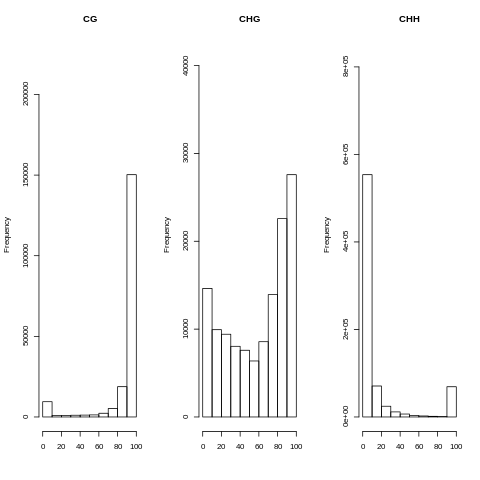

In [38]:
#@title Histogramas por contexto
%%R
f.plot.histogram(mePerc)
#save
pdf(file.path("/content/plots/histograma.pdf"))
f.plot.histogram(mePerc)
invisible(dev.off())

Metilación porcentual 


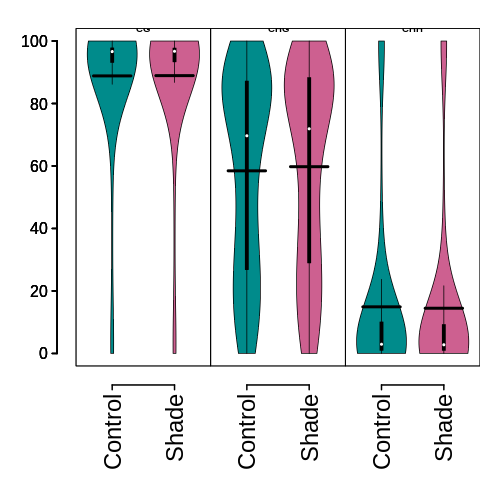

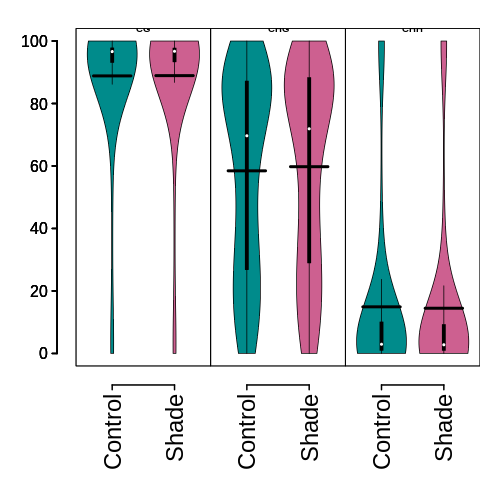

In [40]:
#@title Violin plots
%%R
aveData<-f.average.by.group(infileName)
mePerc <- f.load.methylation.bed(infileName, percentages = TRUE) # see commonFunctions.R
allMeans<-f.plot.violin(aveData, mePerc)
cat("Metilación porcentual \n")
f.plot.violin(aveData, mePerc)
write.csv(round(allMeans, 3), file.path("/content/results/methylationLevelsViolinPlot_means.csv"))  


Metilación porcentual


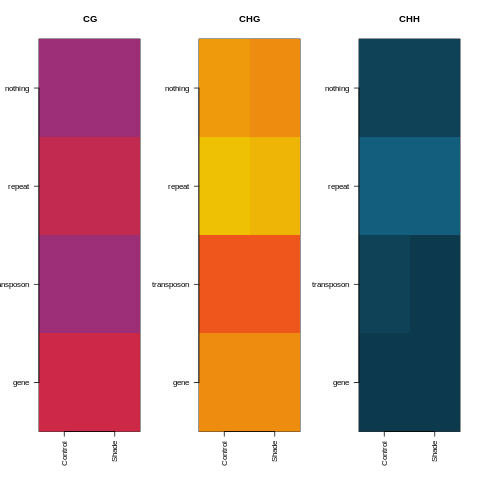

In [41]:
#@title Heatmap
%%R
methPerFeature<-f.plot.heatmap(aveData, mePerc)
cat("Metilación porcentual\n")
pdf("methylationLevelsPerFeature.pdf")
f.plot.heatmap(aveData, mePerc)
invisible(dev.off())
write.csv(methPerFeature, file="/content/results/methylationLevelsPerFeature.csv")

<a name="step-2.4"></a>
## Citosinas diferencialmente metiladas 

Se realizará 
- un análisis exploratorio mediante un análisis de componentes principales para cada contexto. A partir de la matriz de distancia generada, se realizará un análisis permutacional de la varianza.
- un análisis estadístico mediante DSS para determinar C's diferencialmente metiladas.

initial  value 36.120155 
iter   5 value 27.601499
iter  10 value 25.377226
iter  10 value 25.368984
iter  15 value 24.527043
final  value 24.411123 
converged
###
initial  value 38.022343 
iter   5 value 25.866972
iter  10 value 25.179448
final  value 24.991083 
converged
###
initial  value 38.292668 
iter   5 value 27.100305
iter  10 value 25.104175
iter  15 value 23.379774
iter  20 value 22.757629
iter  20 value 22.755606
iter  20 value 22.736110
final  value 22.736110 
converged
###
initial  value 36.120155 
iter   5 value 27.601499
iter  10 value 25.377226
iter  10 value 25.368984
iter  15 value 24.527043
final  value 24.411123 
converged
###
initial  value 38.022343 
iter   5 value 25.866972
iter  10 value 25.179448
final  value 24.991083 
converged
###
initial  value 38.292668 
iter   5 value 27.100305
iter  10 value 25.104175
iter  15 value 23.379774
iter  20 value 22.757629
iter  20 value 22.755606
iter  20 value 22.736110
final  value 22.736110 
converged
###


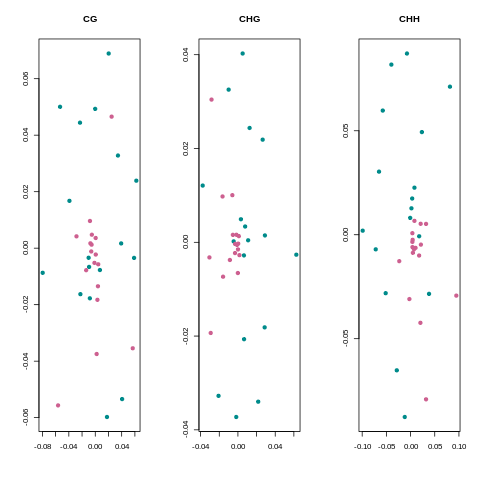

In [43]:
#@title MDS
%%R
adonisResult<-f.plot.isoMDS(filteredMeth)
write.csv(adonisResult, file = paste0("/content/results/adonis.csv"), row.names = TRUE)
pdf(paste0("/content/plots/isoMDS.pdf"), height = 4, width = 10)
f.plot.isoMDS(filteredMeth)
invisible(dev.off())

In [44]:
#@title  Determinación de citosinas diferencialmente metiladas (DMC)
%%R
forDSS<-f.format4DSS(filteredMeth)
myBS <- suppressWarnings(makeBSseqData(forDSS, names(forDSS)))
sampleTab <- f.read.sampleTable("Treat") 
allSamples <- gsub("_total$", "", grep("_total$", colnames(filteredMeth), value = TRUE))
sampleTab <- sampleTab[allSamples,]
myFit <- DMLfit.multiFactor(myBS, sampleTab, formula=~Treat)
DMCresult <- DMLtest.multiFactor(myFit, term="Treat")
cat("\n Vista previa del resultado")
DMCresult[1:10,]
write.csv(DMCresult, "/content/results/DMC_analysis.csv",row.names = FALSE)

#@title Aca se puede cortar
DMCresult<-read.csv("/content/results/DMC_analysis.csv")
col2merge<-c('chr','pos')

DMCresult$chrPos <- apply( DMCresult[ , col2merge] , 1 , paste , collapse = "-" )
DMCresult<-DMCresult[order(DMCresult$chrPos),]
filteredMeth$chrPos <- apply( filteredMeth[ ,col2merge] , 1 , paste , collapse = "-" )
filteredMeth<-filteredMeth[order(filteredMeth$chrPos),]
DMCafterFDR<-subset(DMCresult, DMCresult$fdrs <= 0.05)
uniReg<-unique(DMCafterFDR$chr)
chrDMCafterFDR<-matrix(NA, nrow=length(uniReg), ncol = 2)  
for(j in 1:length(uniReg)){
  hits<-sum(DMCafterFDR$chr==uniReg[j])
  colnames(chrDMCafterFDR) <- c("chr","ocurrences")
  chrDMCafterFDR[j,1]<-uniReg[j]
  chrDMCafterFDR[j,2]<-hits
}
chrDMCafterFDR<-data.frame(chrDMCafterFDR)
chrDMCafterFDR <- chrDMCafterFDR[order(-chrDMCafterFDR$ocurrences),]
write.table(DMCafterFDR,"/content/results/DMC_afterFDR.csv",row.names = FALSE, sep="\t", col.names=T, quote=FALSE)


Fitting DML model for CpG site: 
 Vista previa del resultado

In [45]:
#@title Manhattan plot
%%R
f.plot.manhattan(DMCresult,chrDMCafterFDR)
pdf(paste0("/content/plots/manhattanPlot.pdf"))
f.plot.manhattan(DMCresult,chrDMCafterFDR)
dev.off()

R[write to console]: Error in eval(e, x, parent.frame()) : object 'context' not found

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In file.create(f.tg) :
R[write to console]: 
 
R[write to console]:  cannot create file '/usr/lib/R/doc/html/packages.html', reason 'No such file or directory'

R[write to console]: 2: 
R[write to console]: In make.packages.html(.Library) :
R[write to console]:  cannot update HTML package index




Error in eval(e, x, parent.frame()) : object 'context' not found


RInterpreterError: ignored

<a name="step-3"></a>
# Guardar en Drive

In [49]:
#@title Guardar archivos en el Drive personal
%%bash
#mkdir ../drive/MyDrive/EpiEvo/TP_4
#cd ..
#cp -r {plots,rawData,results} drive/MyDrive/EpiEvo/TP_4/
#ls drive/MyDrive/EpiEvo/TP_4

drive
methylation.bed
plots
rawData
results
plots
rawData
results
